In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
import random
import copy
from tqdm import tqdm
from collections import deque
import torch.nn.functional as F

In [2]:
import numpy as np

# Four rooms environment class copied and pasted from my ex0 submission
class Environment:
    
    def __init__(self, rows, cols, walls):
        
        self.rows = rows
        self.cols = cols
        self.walls = walls
        self.x = 0
        self.y = 0
        self.x_prev = 0
        self.y_prev = 0        
                
    def step(self, action):
        self.x_prev=self.x
        self.y_prev=self.y
        if action == "LEFT":
            self.y=self.y-1
            self.correct()
            return self.reward()
        elif action == "RIGHT":
            self.y=self.y+1
            self.correct()
            return self.reward()
        elif action == "DOWN":
            self.x=self.x+1
            self.correct()
            return self.reward()
        elif action == "UP":
            self.x=self.x-1
            self.correct()
            return self.reward()
        
    def reward(self):
        if ((self.x, self.y)) == (self.rows-1, self.cols-1):
            return (1, True)
        else:
            return (0, False)
        
    def correct(self):
        if self.x<0:
            self.x=self.x_prev
        elif self.x==self.rows:
            self.x=self.x_prev
        elif self.y<0:
            self.y=self.y_prev
        elif self.y==self.cols:
            self.y=self.y_prev
        elif ((self.x, self.y)) in self.walls:
            self.x=self.x_prev
            self.y=self.y_prev
            
    def restart(self):
        self.x = 0
        self.y = 0
        self.x_prev = 0
        self.y_prev = 0
        
    def loc(self):
        return (self.x, self.y)

In [3]:
# Environment Hyperparameters
action_space = ["UP", "DOWN", "LEFT", "RIGHT"]
rows = 11
cols = 11
walls = [
#     (5, 0),
#     (5, 2),
#     (5, 3),
#     (5, 4),
#     (5, 5),
#     (4, 5),
#     (4, 6),
#     (4, 7),
#     (4, 9),
#     (4, 10),
#     (0, 5),
#     (2, 5),
#     (3, 5),
#     (6, 5),
#     (7, 5),
#     (9, 5),
#     (10, 5),
]

In [4]:
environment = Environment(rows, cols, walls)

In [5]:
class Transition():
    
    def __init__(self, state, action, state_new, reward, term):
        self.state = state
        self.action = action
        self.state_new = state_new
        self.reward = reward
        self.term = term
        
class ReplayMemory():

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
#dqn model clas 
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 2, 1)
        self.conv2 = nn.Conv2d(8, 16, 2, 1)
        self.lin1 = nn.Linear(64,32)
        self.lin2 = nn.Linear(32,4)
        self.drop = nn.Dropout(0.4)

    def forward(self, x, batch_size):
        
        x = x.reshape(batch_size, 2, 1)
        board_states = []
        for state in x:
            board = np.zeros((rows,cols))
            board[int(state[0])][int(state[1])] = 1
            board_states.append(board)

        x = torch.tensor(board_states).float()
        x = x.reshape(batch_size, 1, rows, cols)
        x = nn.ReLU()(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = nn.ReLU()(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.drop(x)
        x = x.reshape(batch_size,-1)
        x = nn.ReLU()(self.lin1(x))
        x = self.lin2(x)
        return x

In [7]:
def get_action(net, state, epsilon, batch_size):
    greedy = np.random.choice([True, False], p=[1-epsilon, epsilon])
    if greedy:
        action = torch.argmax(net(torch.tensor(state).float(), batch_size)[0], dim=0).item()
    else:
        action = random.choice([0,1,2,3])
    return action

In [8]:
class Agent():
    
    def __init__(self):
        
        #hyperparameters
        self.exp_replay_size = 100000
        self.gamma = 0.99
        self.epsilon = 0.1
        self.num_episodes = 500
        self.batch_size = 64
        self.steps = 0
        self.loss_func = nn.MSELoss()
        self.max_moves_per_game = 1000
        self.lr = 1e-4
        self.eps_decay = 5e-7
        
        #networks
        self.QNet = DQN()
        self.TNet = DQN()
        self.TNet.eval()
        self.optimizer = torch.optim.Adam(lr=self.lr, params=self.QNet.parameters())
        
        #replay buffer
        self.ER = ReplayMemory(self.exp_replay_size)

In [9]:
def optimize(agent):
    agent.QNet.train()
    sample_transitions = agent.ER.sample(agent.batch_size)
    
    if agent.steps%1000==0 and len(agent.ER)>=agent.batch_size:
        agent.TNet.load_state_dict(agent.QNet.state_dict())

    #calculate q-values and expected values
    qp = agent.QNet(torch.tensor([transition.state for transition in sample_transitions]).float(), agent.batch_size)
    #get index for the choosen action 
    qa = [transition.action for transition in sample_transitions]
    qp = torch.tensor([a[idx] for a, idx in list(zip(qp,qa))])
    #get expected returns using target network 
    qn = agent.TNet(torch.tensor([transition.state_new for transition in sample_transitions]).float(), agent.batch_size)
    qn = torch.max(qn, dim=1).values
    qn = qn + torch.tensor([transition.reward for transition in sample_transitions])
    qn = agent.gamma * qn
    #get terminated boolean values
    term_flags = [transition.term for transition in sample_transitions]
    for idx, flag in enumerate(term_flags):
        if flag:
            qn[idx]=0
    #decay exploration
#     agent.epsilon = max(0, agent.epsilon-agent.eps_decay)
    return agent.loss_func(qp, qn)

In [10]:
agent = Agent()
losses = []
steps2finish = []

for episode in tqdm(range(agent.num_episodes)):
    
    environment = Environment(rows, cols, walls)
    moves = 0

    while moves < agent.max_moves_per_game:
        
        agent.QNet.eval()
        #observation
        state = environment.loc()
        action = get_action(agent.QNet, state, agent.epsilon, 1)
        reward, terminated = environment.step(action_space[action])
        state_new = environment.loc()
        #append to replay buffer
        agent.ER.push(state, action, state_new, reward, terminated)
        moves +=1
            
        #increament step count
        agent.steps+=1
        if len(agent.ER)>=agent.batch_size and agent.steps%256==0:
            agent.optimizer.zero_grad()
            loss = optimize(agent)
            loss.backward()
            agent.optimizer.step()
            losses.append(loss.item())
        
        #break when episode is complete
        if terminated:
            break
                
    steps2finish.append(moves)

100%|██████████| 500/500 [03:46<00:00,  2.21it/s]


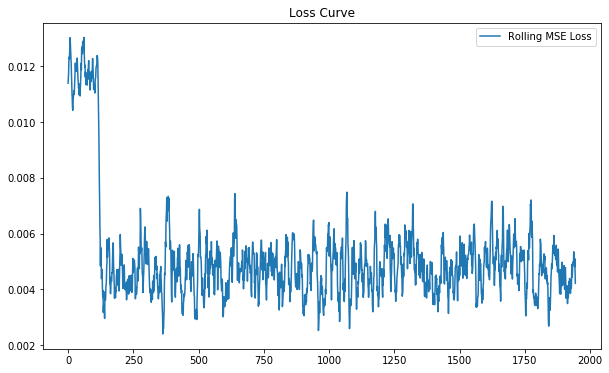

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title('Loss Curve')
plt.plot(np.convolve(losses, np.ones(10), 'valid') / 10, label='Rolling MSE Loss')
plt.legend()
plt.show()

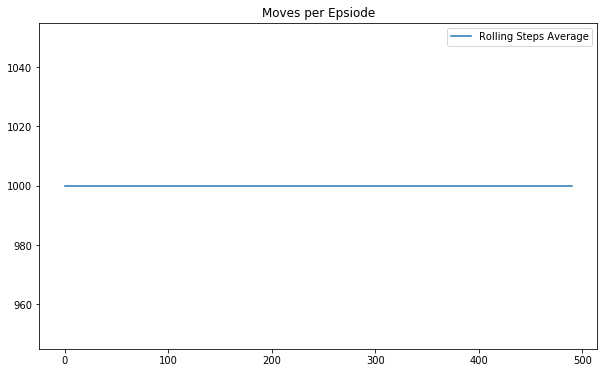

In [12]:
plt.figure(figsize=(10,6))
plt.title('Moves per Epsiode')
plt.plot(np.convolve(steps2finish, np.ones(10), 'valid') / 10, label='Rolling Steps Average')
plt.legend()
plt.show()